In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from scipy.optimize import brute

In [2]:
df = pd.read_csv("resources/BTCUSD.csv", index_col=0, parse_dates=True, usecols=["Date", "Close"])

In [3]:
df.head()

,Close
Date,
2016-01-08,453.230011
2016-01-09,447.610992
2016-01-10,447.990997
2016-01-11,448.428009
2016-01-12,435.690002


In [4]:
def set_returns(df):
    df["Returns"] = np.log(df["Close"].pct_change() + 1)
    return df

In [5]:
set_returns(df.copy()).head()

,Close,Returns
Date,,
2016-01-08,453.230011,NaN
2016-01-09,447.610992,-0.012475
2016-01-10,447.990997,0.000849
2016-01-11,448.428009,0.000975
2016-01-12,435.690002,-0.028817


In [6]:
def set_sma(df, period = 14):
    df["SMA " + str(period)] = ta.SMA(df["Close"], timeperiod=period)
    return df

In [7]:
set_sma(df.copy(), 20).head()

,Close,SMA 20
Date,,
2016-01-08,453.230011,NaN
2016-01-09,447.610992,NaN
2016-01-10,447.990997,NaN
2016-01-11,448.428009,NaN
2016-01-12,435.690002,NaN


In [11]:
def set_strategy(df, sma_f, sma_s):
    df["Position"] = np.where(df["SMA " + str(sma_f)] > df["SMA " + str(sma_s)], 1, -1)
    df["Strategy"] = df["Position"].shift(1) * df["Returns"]
    return df

In [18]:
def handle_strategy(sma_f, sma_s):
    data = df.copy()
    set_returns(data)
    set_sma(data, sma_f)
    set_sma(data, sma_s)
    data.dropna(inplace=True)
    set_strategy(data, sma_f, sma_s)
    data.dropna(inplace=True)
    return data

In [19]:
handle_strategy(20, 50).head()

,Close,Returns,SMA 20,SMA 50,Position,Strategy
Date,,,,,,
2016-02-27,432.519012,0.000849,410.495047,401.792020,1,0.000849
2016-02-28,433.503998,0.002275,413.497897,401.509880,1,0.002275
2016-02-29,437.696991,0.009626,416.581297,401.304000,1,0.009626
2016-03-01,435.122986,-0.005898,419.254997,401.037899,1,-0.005898
2016-03-02,423.989014,-0.025921,421.471748,400.803879,1,-0.025921


In [20]:
def get_compound_return(df):
    return df[["Returns", "Strategy"]].sum().apply(np.exp)

In [21]:
handle_strategy(20, 50).pipe(get_compound_return)

Returns     44.622550
Strategy    83.412449
dtype: float64

In [30]:
def stats_sma_strategy(df):
    days_of_trading = 365
    print("========== TOTAL RETURNS ==========")
    print(df[["Returns", "Strategy"]].sum())
    print("========== ANNUAL RETURNS ==========")
    print(df[["Returns", "Strategy"]].mean() * np.sqrt(days_of_trading))
    print("========== ANNUAL VOLATILITY ==========")
    print(df[["Returns", "Strategy"]].std() * np.sqrt(days_of_trading))
    df["Cumulative Return"] = df[["Returns"]].cumsum().apply(np.exp)
    df["Cumulative Strategy"] = df[["Strategy"]].cumsum().apply(np.exp)
    print("========== CUMULATIVE RETURNS ==========")
    print(df[["Cumulative Return", "Cumulative Strategy"]].iloc[-1])
    return df

In [31]:
def plot_sma_strategy(df, sma_f, sma_s):
    df[["Cumulative Return", "Cumulative Strategy"]].plot(figsize=(20, 6), title="Cumulative Returns SMA Strategy " + str(sma_f) + " " + str(sma_s))
    df.loc[:, ["Close", "SMA " + str(sma_f), "SMA " + str(sma_s), "Position"]].plot(figsize=(20, 6), title="Close Price SMA Strategy " + str(sma_f) + " " + str(sma_s), secondary_y="Position")
    plt.show()

In [32]:
df_btcusd = handle_strategy(50, 150)

In [34]:
df_btcusd = stats_sma_strategy(df_btcusd)

========== TOTAL RETURNS ==========
Returns     3.512687
Strategy    4.540850
dtype: float64
========== ANNUAL RETURNS ==========
Returns     0.029357
Strategy    0.037950
dtype: float64
========== ANNUAL VOLATILITY ==========
Returns     0.770212
Strategy    0.769837
dtype: float64
========== CUMULATIVE RETURNS ==========
Cumulative Return      33.538254
Cumulative Strategy    93.770457
Name: 2022-09-08 00:00:00, dtype: float64


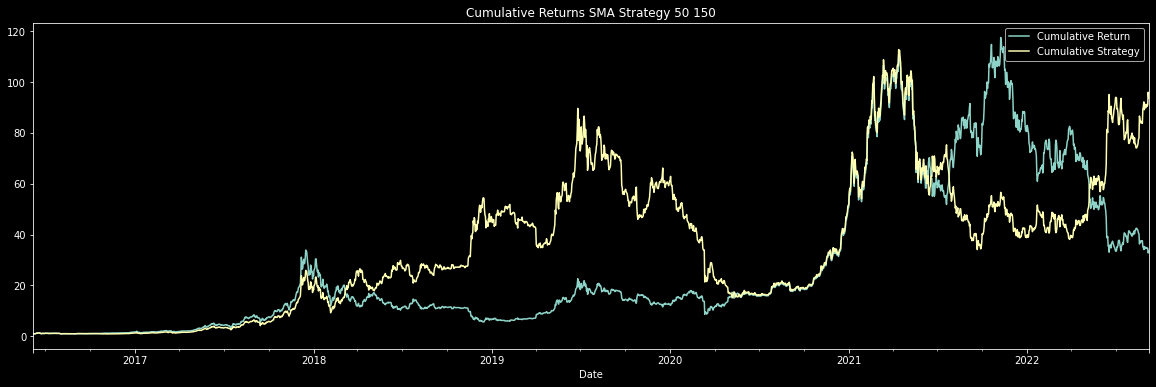

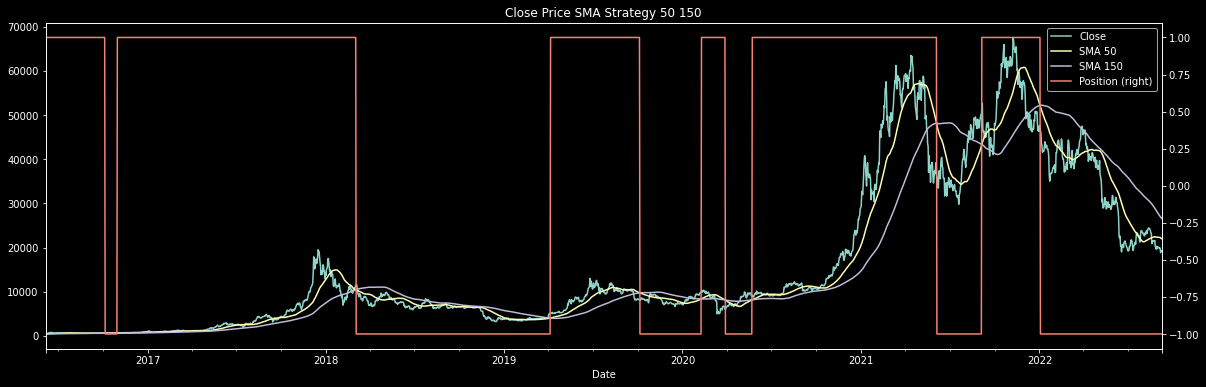

In [35]:
plot_sma_strategy(df_btcusd, 50, 150)

In [36]:
def optimize_sma_strategy(sma_values):
    df_optimize = handle_strategy(sma_values[0], sma_values[1])
    return -get_compound_return(df_optimize)["Strategy"]

In [ ]:
brute(optimize_sma_strategy, ((10, 50, 1), (80, 200, 1)))